In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import networkx_viewer as nxview
import matplotlib.pyplot as plt
import math
from scipy import stats
from itertools import product

import as_proc as proc

# HOW TO USE
To perform the analysis of AS graph with this Jupyter Notebook, you have to:
 1. Specify in `data_dir` the directory containing monthly updates from CAIDA
 2. Specify in `routeviews_dir` the directory containing IPv4 to AS mappings
 2. Specify the starting date of the analysis in `starting_date`
 3. Specify the ending date of the analysis in `ending_date`

In [2]:
data_dir = "asdata/"
routeviews_dir = "ip2as/"

In [4]:
starting_date = {'year':2019, 'month':12}
ending_date = {'year':2020, 'month':3}

It's all set!

### Helper functions

In [5]:
def to_dict_key(year_param, month_param):
    return str(year_param) + str(month_param).zfill(2)

In [6]:
def to_date(point_key):
    return point_key[2:4] + '/' + point_key[4:]

In [7]:
# Max number of x-labels to show in graphs
xtick_max_num = 10

## Load CAIDA data

Relation types to IDs conversion (adopted to numerically manipulate numpy arrays):
    - peer-peer:         0
    - provider-customer:-1
    - customer-provider: 1

In [8]:
as_data = dict()

for (year, month) in product(range(starting_date['year'], ending_date['year']+1), range(1, 13)):
    if not ((year == starting_date['year'] and month < starting_date['month']) or 
        (year == ending_date['year'] and month > ending_date['month'])):
        date_label = to_dict_key(year, month)
        as_data[date_label] = proc.load_graph(data_dir + date_label + "01.as-rel2.txt")

For each time $k$ (which represents a particular month), I denote with $\Gamma_k = (A^k, E^k)$ the AS graph. $A^k$ is the set of nodes and $E^k$ is the set of edges.

## Save edges for simulation

In [9]:
# edges_num_by_node = 
# np.savetxt("simulation/202003-nodes.csv")

Select here **year** and **month** to export a *.csv* suitable for the simulation

In [10]:
for_simulation = '202003'
data_point = as_data[for_simulation]['edges']

In [12]:
# Also need to sort according to the destination AS, to use binary search in simulator!!
dp_by_as = np.split(data_point, np.unique(data_point[:,0], return_index=True)[1])[1:]

In [37]:
dp_by_as_sorted = [x[np.argsort(x[:,1]),:] for x in dp_by_as]

In [38]:
#
# OPTIMIZATION
# Apply stub AS reduction
#
stub_as = np.squeeze(np.array(list(filter(lambda x: len(x) == 1, map(lambda x: x[:,0], dp_by_as_sorted)))))
non_stub_as = np.setdiff1d(as_data[for_simulation]['nodes'], stub_as)
stub_as, non_stub_as

(array([    13,     15,     22, ..., 398252, 398256, 398273]),
 array([     1,      2,      3, ..., 398236, 398247, 398255]))

In [41]:
# Delete stub ASes
dp_filtered = list(filter(lambda x: len(x) > 1, dp_by_as_sorted))
# Delete references in destinations
dp_filtered = [x[np.in1d(x[:,1], non_stub_as),:] for x in dp_filtered]

In [42]:
print("Applied stub AS reduction: factor %f %%, from %d to %d nodes" % (len(dp_filtered)/float(len(dp_by_as))*100, len(dp_by_as), len(dp_filtered)))

Applied stub AS reduction: factor 64.241256 %, from 67961 to 43659 nodes


In [43]:
to_export = np.concatenate(dp_filtered)
to_export

array([[     1,   8458,      1],
       [     1,  11537,      1],
       [     1,  26114,      1],
       ...,
       [398247,  36103,      1],
       [398255,    174,      1],
       [398255,   3356,      1]])

In [44]:
np.savetxt("simulation/" + for_simulation + "-edges.csv", to_export, fmt='%d', delimiter=',')

In [45]:
to_export[-10:]

array([[398223,  63927,      0],
       [398223,  64271,      0],
       [398230,  32281,      1],
       [398230,  63107,      1],
       [398236, 393775,      1],
       [398236, 397949,     -1],
       [398247,    209,      1],
       [398247,  36103,      1],
       [398255,    174,      1],
       [398255,   3356,      1]])

## Load IP prefixes (Routeviews)

In [14]:
ip2as_file = pd.read_csv(routeviews_dir + "routeviews_2003.pfx2as", sep='\t')

In [173]:
conversions = ip2as_file.to_numpy()

In [174]:
conversions = conversions[:, [2, 1, 0]]
conversions.shape

(852307, 3)

In [175]:
# For multihomed sites: Take the first AS origin
multi_homed_idxs = np.where(np.vectorize(lambda x: '_' in x)(conversions[:,0]))
if multi_homed_idxs[0].shape[0] > 0:
    conversions[multi_homed_idxs, 0] = np.vectorize(lambda x: x.split('_')[0])(conversions[multi_homed_idxs, 0])

In [176]:
# For AS sets: Take only the first one
as_sets_idxs = np.where(np.vectorize(lambda x: ',' in x)(conversions[:,0]))
if as_sets_idxs[0].shape[0] > 0:
    conversions[as_sets_idxs, 0] = np.vectorize(lambda x: x.split(',')[0])(conversions[as_sets_idxs, 0])

In [177]:
# Converting AS numbers to 64-byte integers
conversions[:,0] = conversions[:,0].astype('int64')

In [178]:
conversions

array([[56203, 22, '1.0.4.0'],
       [56203, 24, '1.0.4.0'],
       [56203, 24, '1.0.5.0'],
       ...,
       [58519, 24, '223.255.252.0'],
       [58519, 24, '223.255.253.0'],
       [55415, 24, '223.255.254.0']], dtype=object)

## Processing differences

### Nodes evolution

#### By month

In [92]:
x_vals = list(as_data.keys())
x_vals.sort()

In [93]:
as_variations = []
for (bk, nx) in zip(x_vals[:-1], x_vals[1:]):
    as_down = np.setdiff1d(as_data[bk]['nodes'], as_data[nx]['nodes'])
    as_up = np.setdiff1d(as_data[nx]['nodes'], as_data[bk]['nodes'])
    as_variations.append([as_down.shape[0]/float(as_data[bk]['nodes'].shape[0]),
                          as_up.shape[0]/float(as_data[nx]['nodes'].shape[0])])
    
as_variations = np.array(as_variations) * 100

`as_variations` is a *numpy* array of the form: \
$$   [[d_0, a_0],\\ [d_1. a_1],\\ ... \\ [d_n, a_n]]  $$
where:
 - $d_k$ is the percentage of AS nodes, included at time `k`, that disappeared at time `k+1`
 - $a_k$ is the percentage of new ASes, i.e. those included at `k+1` that were absent at time `k` 

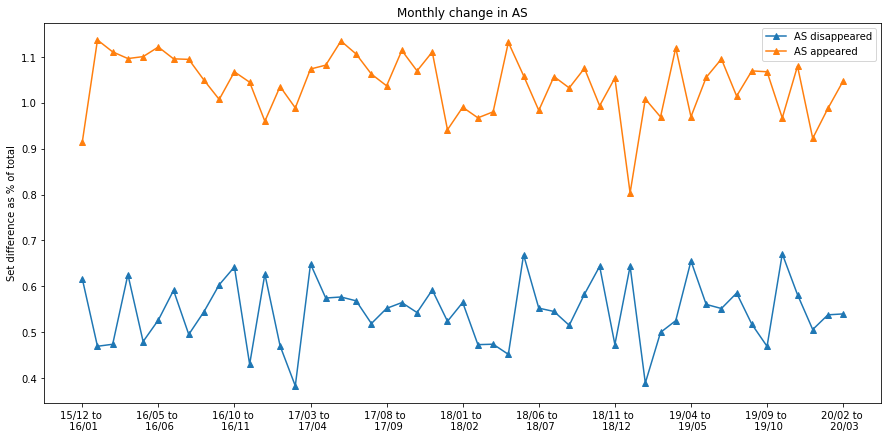

In [94]:
as_graph_x_label = list(map(lambda x: to_date(x[0]) + " to \n " + to_date(x[1]), zip(x_vals[:-1], x_vals[1:])))
as_graph_x_ticks = as_graph_x_label[0::int(len(as_graph_x_label)/xtick_max_num)]
plt.figure(figsize=(15, 7))
plt.plot(as_graph_x_label, as_variations[:,0], '^-', label='AS disappeared')
plt.plot(as_graph_x_label, as_variations[:,1], '^-', label='AS appeared')
plt.ylabel('Set difference as % of total')
plt.title('Monthly change in AS')
plt.xticks(as_graph_x_ticks)
plt.legend()

#### Cumulative
Here, cumulative differences are shown

In [95]:
# The list of ASes at the starting date
union_set = as_data[to_dict_key(starting_date['year'], starting_date['month'])]['nodes']
union_size = float(union_set.shape[0])
intersect_set = as_data[to_dict_key(starting_date['year'], starting_date['month'])]['nodes']
intersect_size = float(intersect_set.shape[0])

In [96]:
as_cumul_variations = []
for mth in x_vals:
    as_down = np.setdiff1d(intersect_set, as_data[mth]['nodes'])
    as_up = np.setdiff1d(as_data[mth]['nodes'], union_set)
    as_cumul_variations.append([as_down.shape[0]/intersect_size, as_up.shape[0]/float(as_data[mth]['nodes'].shape[0])])
    union_set = np.union1d(union_set, as_data[mth]['nodes'])
    union_size = float(union_set.shape[0])
    intersect_set = np.intersect1d(intersect_set, as_data[mth]['nodes'])
    intersect_size = float(intersect_set.shape[0])
    
as_cumul_variations = np.array(as_cumul_variations) * 100

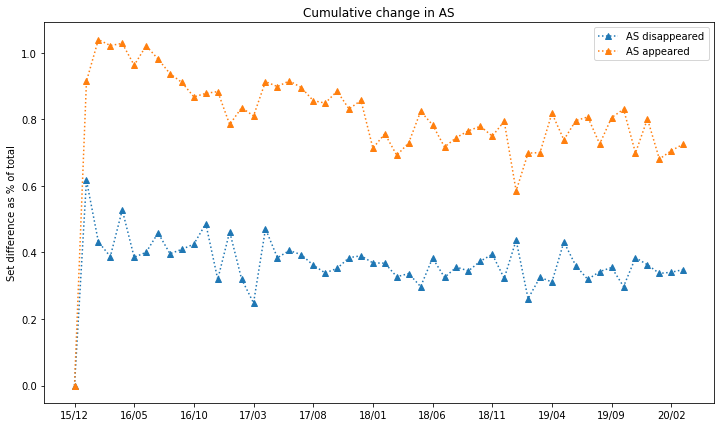

In [97]:
as_graph_cumul_x_label = list(map(lambda x: to_date(x), x_vals))
as_graph_cumul_x_ticks = as_graph_cumul_x_label[0::int(len(as_graph_cumul_x_label)/xtick_max_num)]
plt.figure(figsize=(12, 7))
plt.plot(as_graph_cumul_x_label, as_cumul_variations[:,0], '^:', label='AS disappeared')
plt.plot(as_graph_cumul_x_label, as_cumul_variations[:,1], '^:', label='AS appeared')
plt.ylabel('Set difference as % of total')
plt.title('Cumulative change in AS')
plt.xticks(as_graph_cumul_x_ticks)
plt.legend()

**TODO**: Use final intersection

For time $k$, `AS appeared` is the number (as percentage) of ASes that had never happeared before, namely: \
$$ \frac{\big \lvert A^k \setminus \bigcup_{j=0}^{k-1} A^j \big \rvert}{\lvert A^k \rvert} $$

`AS disappeared` is the percentage of ASes always present up to time $k-1$ that are not found at time $k$, i.e. \
$$ \frac{\big \lvert \bigcap_{j=0}^{k-1} A^j \setminus A^k \big \rvert}{\big \lvert \bigcap_{j=0}^{k-1} A^j \big \rvert} $$

Now, I repeat the last analysis taking advantage of information from the future. At each time $k$, I calculate the percentage of ASes that differ from the intersection (here, always calculated over the entire period)

In [206]:
as_future_variations = []
for mth in x_vals:
    as_var = np.setdiff1d(as_data[mth]['nodes'], intersect_set)
    as_future_variations.append(as_var.shape[0]/as_data[mth]['nodes'].shape[0])
    
as_future_variations = np.array(as_future_variations) * 100

In [207]:
as_future_variations

array([17.46284803, 17.70961455, 18.26178483, 18.78536613, 19.17029107,
       19.67491688, 20.15569346, 20.56115739, 21.04001743, 21.44082952,
       21.76025044, 22.09523127, 22.57651017, 22.83615458, 23.27452364,
       23.74138566, 24.06760721, 24.45540771, 24.87951495, 25.28605298,
       25.6945631 , 26.05716423, 26.46601285, 26.85560508, 27.23743872,
       27.54294473, 27.85307829, 28.21156195, 28.57705952, 29.06519647,
       29.34409982, 29.65041979, 30.01271384, 30.37686914, 30.72180715,
       30.96594968, 31.36905232, 31.47935147, 31.90529876, 32.22684557,
       32.63210075, 32.84536274, 33.17968102, 33.54523227, 33.83238999,
       34.19981541, 34.59565956, 34.79082321, 35.11771551, 35.3895525 ,
       35.68195936, 36.01035888])

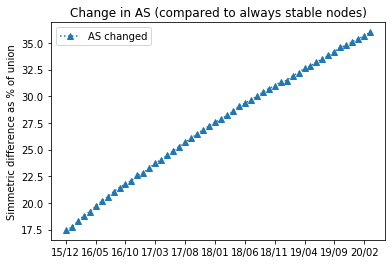

In [208]:
as_graph_cumul_x_label = list(map(lambda x: to_date(x), x_vals))
as_graph_cumul_x_ticks = as_graph_cumul_x_label[0::int(len(as_graph_cumul_x_label)/xtick_max_num)]
#plt.figure(figsize=(12, 7))
plt.plot(as_graph_cumul_x_label, as_future_variations, '^:', label='AS changed')
plt.ylabel('Simmetric difference as % of union')
plt.title('Change in AS (compared to always stable nodes)')
plt.xticks(as_graph_cumul_x_ticks)
plt.legend()

### Study of unstable ASes

In [179]:
# Delete AS that are not included in the union of nodes over the period
conversions = conversions[np.where(conversions[:,0] <= union_set.max())]

In [162]:
# Compute the number of addresses advertised by each AS
def calc_as_addr_sum(as_information):
    as_information = as_information[np.argsort(as_information[:,0]), :]
    _, as_idxs = np.unique(as_information[:,0], return_index=True)
    by_as_list = np.split(as_information, as_idxs[1:])
    return np.array([[x[0,0], (1 << (32-x[:,1])).sum()] for x in by_as_list])

In [101]:
unstable_as = np.setdiff1d(union_set, intersect_set)

In [103]:
unstable_prefixes = conversions[np.where(np.in1d(conversions[:,0], unstable_as)),:]

In [120]:
unstable_prefixes = unstable_prefixes[0]

I now estimate the difference in the average number of IP prefixes advertised between the unstable AS and general average. This should give information on the *size* of the unstable ASes

In [181]:
as_addr_num = calc_as_addr_sum(conversions)

In [182]:
unstable_addr_num = calc_as_addr_sum(unstable_prefixes)

In [186]:
print("The general average number of IP addresses per AS is %d whereas, for unstable IPs, it's %d" 
          % (np.average(as_addr_num[:,1]), np.average(unstable_addr_num[:,1])))

The general average number of IP addresses per AS is 58714 whereas, for unstable IPs, it's 4291


This results indicates that, on average, a random AS advertises about **10 times more** IP addresses that a typical *unstable AS*

### Edges evolution

Below, I use the following terms:
 - **stable nodes**: nodes that always appear in data (spanning a certain number of months)
 
Let $S^k = \bigcap_{j=0}^{k-1} A^j$, I denote with $\Gamma_{S^k} = \Gamma \rvert_{S^k}$ the induced subgraph. Furthermore, if $N$ is the end of the period under analysis (the most recent available month), I write $S=S^N$. In other words, $S$ is the set of nodes that are stable across the entire period under examination, I call them **always stable** ($S \subset S^k \forall k$).

#### Edge stability
Which portion of edges appears/disappears from the graph?

In [37]:
# Find the edges of the subgraph
def filter_by_nodes(edges_param, nodes_to_keep):
    # Encode the edges as single 64 integer
    filtered_idxs = np.intersect1d(np.where(np.in1d(edges_param[:,0], nodes_to_keep)),
                                   np.where(np.in1d(edges_param[:,1], nodes_to_keep)))
    return edges_param[filtered_idxs,:]

`stable_edges` contains, for each month $k$, the edges (of $\Gamma^k$) connecting **always stable** nodes only. Hence `stable_edges[k]` = $E_{S}^k$

In [38]:
stable_edges = dict()
for i in x_vals:
    stable_edges[i] = filter_by_nodes(as_data[i]['edges'], intersect_set)

It's reasonable to just look at always stable nodes since, for each time $k$, the induced subgraph $\Gamma_{S}^k$ still contains the vast majority of edges of $\Gamma^k$. \
Below, I compute $m= \min_{k}{\Big(\frac{\lvert E_{S}^k \rvert}{\lvert E^k \rvert}\Big)}$

In [39]:
print("Over the selected period, m = %.2f %%" % (max([stable_edges[i].shape[0]/float(as_data[i]['edges'][:,0].shape[0]) for i in x_vals])*100))

Over the selected period, m = 88.90 %


Now, I encode each edge as a 64-bytes integer for fast comparison, edge $\varepsilon = (x, y)$ is encoded as $\varepsilon = x \cdot 10^6 + y$

In [40]:
fast_edges = dict()
for i in x_vals:
    fast_edges[i] = (stable_edges[i][:,0].astype('int64') * 1000000) + stable_edges[i][:,1].astype('int64')

In [41]:
edges_existence = []
for curr, nxt in zip(x_vals[:-1], x_vals[1:]):
    edges_existence.append([np.union1d(fast_edges[curr], fast_edges[nxt]).shape[0],
                            np.union1d(np.setdiff1d(fast_edges[curr], fast_edges[nxt]), np.setdiff1d(fast_edges[nxt], fast_edges[curr]))[:]])

In [42]:
edges_num_change = [tm[1].shape[0]/float(tm[0]) for tm in edges_existence]

`edges_num_change` is the fraction of edges in the stable subgraph $\Gamma_S^k$ that change after 1 month. In other words,

$$ \text{edges_num_change}[k] = \frac{\lvert E_S^k \triangle E_S^{k+1} \rvert}{\lvert E_S^k \cup E_S^{k+1}\rvert} $$
    
where $ \triangle $ denotes the symmetric set difference.

It can be seen that there is a relatively high variability, for instance 1 over 5 edges of the stable subgraph either appears or disappears between October and November 2019

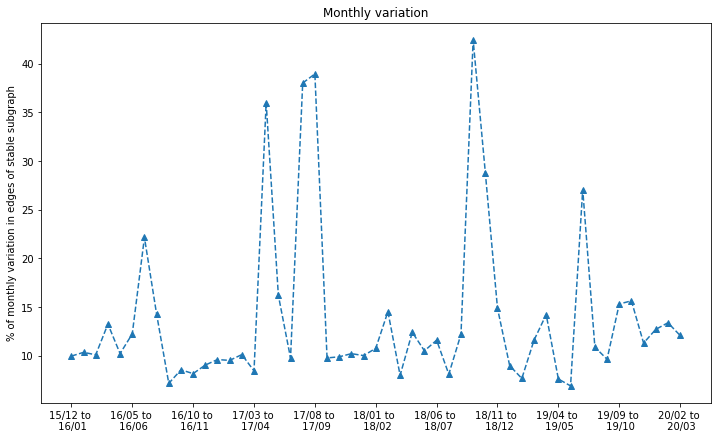

In [44]:
plt.figure(figsize=(12, 7))
plt.plot(as_graph_x_label, list(map(lambda x: 100* x, edges_num_change)), '^--')
plt.ylabel("% of monthly variation in edges of stable subgraph")
plt.xticks(as_graph_x_ticks)
plt.title("Monthly variation");

Although the previous graph gives an idea on the monthly amount of change in AS graph, it falls short of distinguishing between random fluctuations and real topology changes.

#### Cumulative edge change
How many edges are really new?

In [45]:
edge_novelty = []
edge_union = fast_edges[x_vals[0]]
edge_intersection = fast_edges[x_vals[0]]
for curr in x_vals:
    edge_novelty.append([fast_edges[curr].shape[0],
                         edge_intersection.shape[0],
                         np.setdiff1d(fast_edges[curr], edge_union),
                         np.setdiff1d(edge_intersection, fast_edges[curr])])
    edge_union = np.union1d(edge_union, fast_edges[curr])
    edge_intersection = np.intersect1d(edge_intersection, fast_edges[curr])

In [46]:
edge_novelty_fraction = [p[2].shape[0]/float(p[0]) for p in edge_novelty]
edge_disappearence_fraction = [p[3].shape[0]/float(p[1]) for p in edge_novelty]

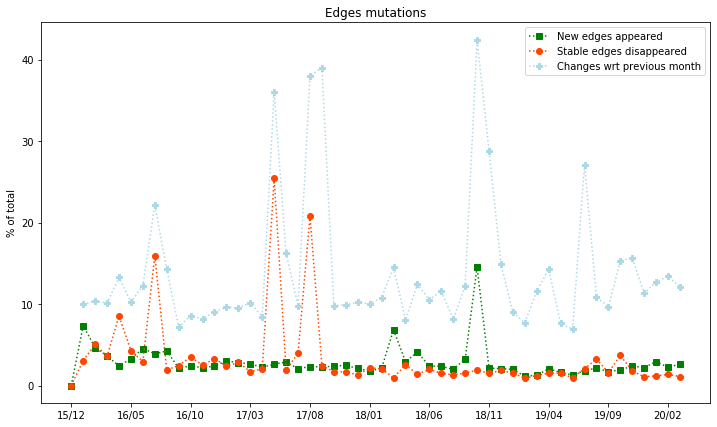

In [88]:
plt.figure(figsize=(12, 7))
plt.plot(as_graph_cumul_x_label, list(map(lambda x: 100* x, edge_novelty_fraction)), 's:', label="New edges appeared", color="green")
plt.plot(as_graph_cumul_x_label, list(map(lambda x: 100* x, edge_disappearence_fraction)), 'o:', label="Stable edges disappeared", color="orangered")
plt.plot(as_graph_cumul_x_label[1:], list(map(lambda x: 100* x, edges_num_change)), 'P:', label="Changes wrt previous month", color="lightblue")
plt.xticks(as_graph_cumul_x_ticks)
plt.title("Edges mutations")
plt.ylabel("% of total")
plt.legend()

`edge_novelty_fraction` (green in the graph) represents the fraction of edges at time $k$ that had never appeared previously
`edge_disappearence_fraction` (orange in the graph) represents the fraction of edges that were always present up to time $k-1$ but disappeared at time $k$. In symbols:

$$ \text{edge_novelty_fraction}[k] = \frac{\big \lvert E_S^k \setminus \bigcup_{j=0}^{k-1} E_S^j \big \rvert}{\lvert E_S^k \rvert} $$
and
$$ \text{edge_disappearence_fraction}[k] = \frac{\big \lvert \bigcap_{j=0}^{k-1} E_S^j \setminus E_S^k \big \rvert}{\big \lvert \bigcap_{j=0}^{k-1} E_S^j \big \rvert} $$

**DISCLAIMER**: *It must be noted that the previous metrics are highly unstable at the beginning (first months) and then gradually converge to truthful values*

#### Edge type change
How often edges change their type?

`fast_edges_type` is a dictionary containing, for each time $k$, a numpy array of the encoded edges of the *entire* graph $\Gamma^k$, along with their type

In [51]:
fast_edges_type = dict()
for i in x_vals:
    fast_edges_type[i] = np.concatenate([
        np.expand_dims((as_data[i]['edges'][:,0].astype('int64') * 1000000) + as_data[i]['edges'][:,1].astype('int64'), axis=1), 
        np.expand_dims(as_data[i]['edges'][:,2], axis=1)], axis=1)

`stable_edges_type` is a dictionary containing, for each time $k$, a numpy array of the **sorted** encoded edges of the **stable** subgraph $\Gamma_S^k$ along with their type

In [52]:
stable_edges_type = dict()
for i in x_vals:
    stable_idxs = np.in1d(fast_edges_type[i][:,0], edge_intersection)
    stable_edges_type[i] = fast_edges_type[i][stable_idxs,:][np.argsort(fast_edges_type[i][stable_idxs,0]),:]

In [58]:
# Just a sanity check
assert sum([np.sum(stable_edges_type[a][:,0] != stable_edges_type[b][:,0]) for (a, b) in zip(x_vals[:-1], x_vals[1:])]) == 0, "Didn't successfully compute the sorted stable edges"

In [54]:
edge_type_change_fraction = []
stable_edges_count = float(edge_intersection.shape[0])
for curr, nxt in zip(x_vals[:-1], x_vals[1:]):
    edge_type_change_fraction.append(np.sum(stable_edges_type[curr][:,1] != stable_edges_type[nxt][:,1]) / stable_edges_count)

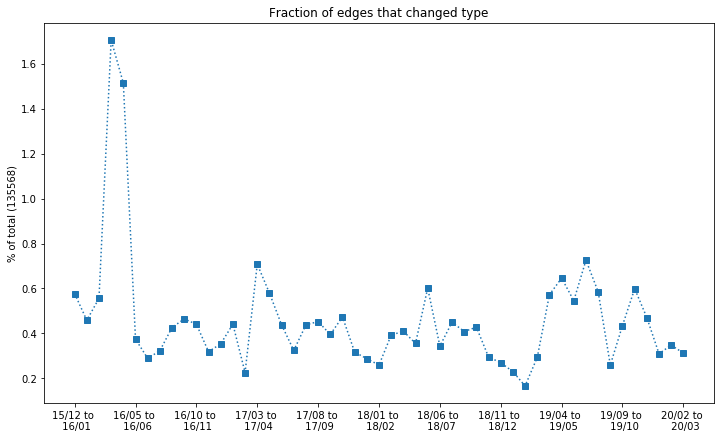

In [56]:
plt.figure(figsize=(12, 7))
plt.plot(as_graph_x_label, list(map(lambda x: 100*x, edge_type_change_fraction)), 's:')
plt.title("Fraction of edges that changed type")
plt.xticks(as_graph_x_ticks)
plt.ylabel("%% of total (%d)" % int(stable_edges_count));

Only a small amount of stable edges change of type (~0.4%)

In [77]:
edge_type_detail = []
for curr, nxt in zip(x_vals[:-1], x_vals[1:]):
    edge_type_detail.append([
        np.sum((stable_edges_type[curr][:,1] * 10 + stable_edges_type[nxt][:,1]) == 10) / stable_edges_count,
        np.sum((stable_edges_type[curr][:,1] * 10 + stable_edges_type[nxt][:,1]) == 1) / stable_edges_count,
        np.sum((stable_edges_type[curr][:,1] * 10 + stable_edges_type[nxt][:,1]) == 9) / stable_edges_count])
edge_type_detail = np.asarray(edge_type_detail)

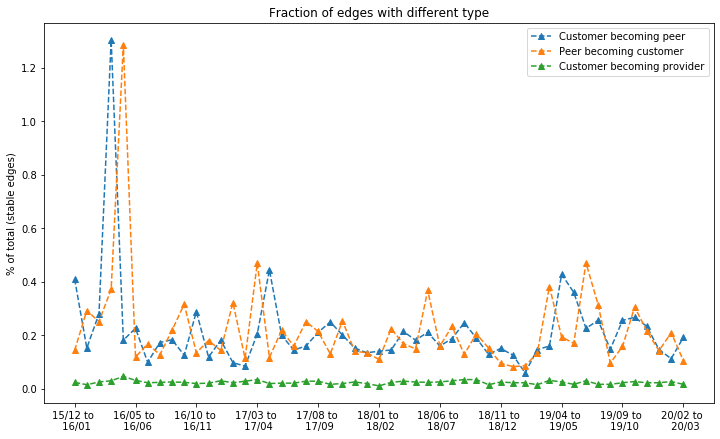

In [87]:
plt.figure(figsize=(12, 7))
plt.plot(as_graph_x_label, 2 * edge_type_detail[:,0] * 100, '^--', label="Customer becoming peer")
plt.plot(as_graph_x_label, 2 * edge_type_detail[:,1] * 100, '^--', label="Peer becoming customer")
plt.plot(as_graph_x_label, 2 * edge_type_detail[:,2] * 100, '^--', label="Customer becoming provider")
plt.xticks(as_graph_x_ticks)
plt.ylabel("% of total (stable edges)")
plt.title("Fraction of edges with different type")
plt.legend()

The previous graph details the nature of type change among edges of the stable subgraph.
It can be seen that:
 1. The number of inversions, i.e. *provider-to-customer* links becoming *customer-to-provider* ($\tau_k(\varepsilon) = 1$ and $\tau_{k+1}(\varepsilon) = -1$), is **very low** as expected
 2. The shape of the other two lines (depicting *customer-to-provider* links becoming *peer-to-peer* and vice versa) are almost **shifted versions** of each other: this suggest that many of those changes are just **noise**

## Lab